#Import Packages

In [ ]:
#newer versions of tensorflow have a stupid bug for saving models with efficientnet B0 backbone
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import print_function
import tensorflow
import json
from tensorflow.keras.datasets import cifar10,cifar100,fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import optimizers
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from keras import models
from keras.utils import plot_model
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.utils import img_to_array, array_to_img


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset=cifar100 #cifar10,cifar100,fashion_mnist
backbone=ResNet50 #VGG16,ResNet50.EfficientNetB0
 

#Class for define model and important methods for data preproccesing and train model

In [ ]:
class NN:
    def __init__(self, train=True):
        if dataset==cifar100: 
          self.num_classes = 100
          self.data_per_class=500

        else : 
          self.num_classes = 10
          self.data_per_class=2000

        self.weight_decay = 0.0005
        self.x_shape = [32, 32, 3]

        self.model = self.build_model()
        if train:
            self.model = self.train(self.model)
        else:
            self.model.load_weights('/content/drive/MyDrive/NN.h5')
    def custom_loss(y_actual, y_pred):
        custom_loss = K.square(y_actual - y_pred)
        return custom_loss

    def build_model(self):
        base_model = backbone(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

        for layer in base_model.layers:
            layer.trainable = True

        model = Sequential()
        weight_decay = self.weight_decay
        model.add(base_model)
        model.add(Flatten())
        if backbone==ResNet50:
            model.add(BatchNormalization())
            model.add(Dense(512 ,kernel_regularizer=regularizers.l2(weight_decay)))
            model.add(Dropout(0.5))
            model.add(Activation('relu'))
            model.add(BatchNormalization())
        if backbone==VGG16:
            model.add(Dense(4096 ,kernel_regularizer=regularizers.l2(weight_decay)))
            model.add(Activation('relu'))
            # model.add(BatchNormalization())
            model.add(Dense(4096 ,kernel_regularizer=regularizers.l2(weight_decay)))
            model.add(Activation('relu'))
        if backbone==EfficientNetB0:
          model.add(Dense(1280,kernel_regularizer=regularizers.l2(weight_decay)))
          model.add(Activation('relu'))
          model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
          model.add(Activation('relu'))


        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))

        return model

    def normalize(self, x_train, x_test):
        mean = np.mean(x_train,axis=(0,1,2,3))
        std = np.std(x_train, axis=(0, 1, 2, 3))
        x_train = (x_train-mean)/(std+1e-7)
        x_test = (x_test-mean)/(std+1e-7)
        return x_train, x_test

    def normalize_production(self, x):
        mean = 120.707
        std = 64.15
        x = (x-mean)/(std+1e-7)
        return x

    def predict(self, x, normalize=True, batch_size=50):
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x, batch_size)

    def train(self, model):
        batch_size = 128
        maxepoches = 100
        learning_rate = 0.001
        lr_decay = 1e-6
        lr_drop = 20
        (x_train, y_train), (x_test, y_test) = dataset.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        y_train=y_train.reshape(y_train.shape[0],1)
        x_train_s= []
        y_train_s= []
        for i in range(self.num_classes):
          c = 0
          for j in range(len(y_train)):
            if c == self.data_per_class:
              break
            if y_train[j][0] == i:
              x_train_s.append(x_train[j])
              y_train_s.append(y_train[j][0])
              c += 1

        x_train, y_train = shuffle(x_train_s, y_train_s)

        x_train = np.array(x_train)
        if dataset==fashion_mnist:
            x_train=np.dstack([x_train.reshape(self.data_per_class*10,28*28,1)] * 3)
            x_train=x_train.reshape(self.data_per_class*10,28,28,3)
            x_train= np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in x_train])
           # x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in x_train])

        x_train, x_test = self.normalize(x_train, x_test)
        y_train = np.array(y_train)

        y_train = tensorflow.keras.utils.to_categorical(y_train, self.num_classes)
        y_test = tensorflow.keras.utils.to_categorical(y_test, self.num_classes)        
        x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size=0.2,shuffle = True,  random_state=42)
    
        def lr_scheduler(self, epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = tensorflow.keras.callbacks.LearningRateScheduler(lr_scheduler)

        # data augmentation
        datagen = ImageDataGenerator(
            featurewise_std_normalization=False,
            samplewise_std_normalization=False)
        
        datagen.fit(x_train)

        sgd = optimizers.SGD(lr=learning_rate,decay=lr_decay, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

        historytemp = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                                steps_per_epoch=x_train.shape[0] // batch_size,
                                epochs=maxepoches,
                                validation_data=(x_valid, y_valid),
                                callbacks=[reduce_lr],
                                verbose=1)

        history_dict = historytemp.history

        # Save the model
        print("batchsize :")
        print(history_dict)
        model.save_weights('/content/drive/MyDrive/NN.h5')
        model.save("/content/drive/MyDrive/Project.h5")
        return model

#Train Model

In [ ]:
print(dataset)
print(backbone)

<module 'keras.api._v2.keras.datasets.cifar100' from '/usr/local/lib/python3.8/dist-packages/keras/api/_v2/keras/datasets/cifar100/__init__.py'>
<function ResNet50 at 0x7fd5d2695dc0>


In [ ]:
mymodel = NN()

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


312/312 [==============================] - 37s 88ms/step - loss: 5.0057 - accuracy: 0.0643 - val_loss: 5.0560 - val_accuracy: 0.0163 - lr: 0.0010
Epoch 2/100
312/312 [==============================] - 28s 89ms/step - loss: 3.9050 - accuracy: 0.2091 - val_loss: 4.1183 - val_accuracy: 0.1773 - lr: 0.0010
Epoch 3/100
312/312 [==============================] - 26s 83ms/step - loss: 3.2778 - accuracy: 0.3177 - val_loss: 3.0618 - val_accuracy: 0.3606 - lr: 0.0010
Epoch 4/100
312/312 [==============================] - 25s 81ms/step - loss: 2.8258 - accuracy: 0.4033 - val_loss: 2.8340 - val_accuracy: 0.4076 - lr: 0.0010
Epoch 5/100
312/312 [==============================] - 26s 83ms/step - loss: 2.4832 - accuracy: 0.4760 - val_loss: 2.6708 - val_accuracy: 0.4330 - lr: 0.0010
Epoch 6/100
312/312 [==============================] - 25s 81ms/step - loss: 2.2053 - accuracy: 0.5361 - val_loss: 2.5857 - val_accuracy: 0.4481 - lr: 0.0010
Epoch 7/100
312/312 [==============================] - 27s 87ms/

#Plot Model

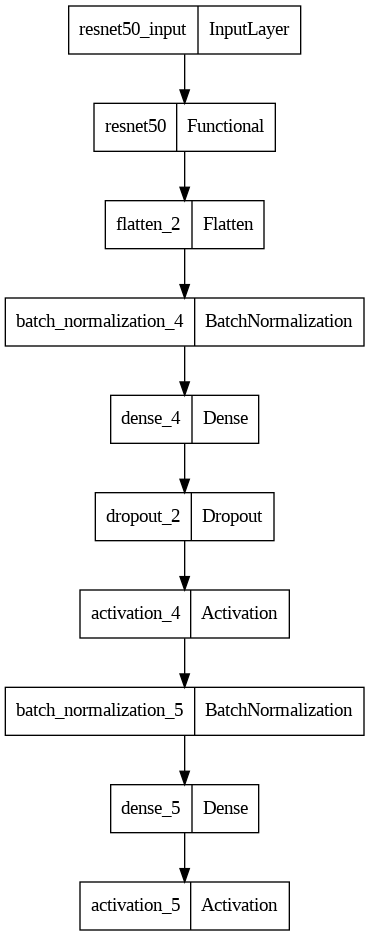

In [ ]:
plot_model(mymodel.model)

In [ ]:
mymodel.model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                      

#Plot accuracy and loss of train and validation

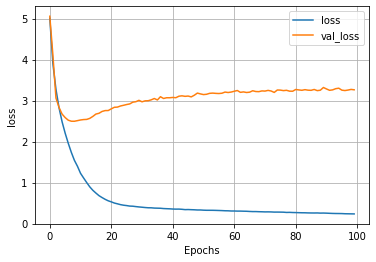

In [ ]:
plt.plot(mymodel.model.history.history['loss'],label = 'loss')
plt.plot(mymodel.model.history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()

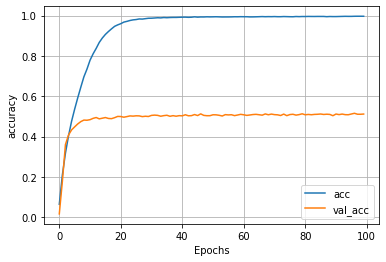

In [ ]:
plt.plot(mymodel.model.history.history['accuracy'],label = 'acc')
plt.plot(mymodel.model.history.history['val_accuracy'],label = 'val_acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.grid()

#Load trained model

In [ ]:
NN_model = models.load_model("/content/drive/MyDrive/Project.h5")

In [ ]:
NN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                      

#Compte CSI for Convolutional layers

In [ ]:
from sklearn.utils import shuffle
(x_train, y_train), (x_test, y_test) = dataset.load_data()
y_train=y_train.reshape(y_train.shape[0],1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
if dataset==cifar100: num_classes = 100
else : num_classes = 10
num_sample_si=250
x_train_s= []
y_train_s= []
for i in range(num_classes):
  c = 0
  for j in range(len(y_train)):
    if c == num_sample_si:
      break
    if y_train[j][0] == i:
      x_train_s.append(x_train[j])
      y_train_s.append(y_train[j][0])
      c += 1

x_train = np.array(x_train_s)
y_train = np.array(y_train_s)
if dataset==fashion_mnist:
    x_train=np.dstack([x_train.reshape(num_sample_si*10,28*28,1)] * 3)
    x_train=x_train.reshape(num_sample_si*10,28,28,3)
    x_train= np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in x_train])
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
x_test.shape

(10000, 32, 32, 3)

In [ ]:
if dataset==fashion_mnist:
    x_test=np.dstack([x_test.reshape(10000,28*28,1)] * 3)
    x_test=x_test.reshape(10000,28,28,3)
    x_test= np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in x_test])

In [ ]:
csi_history = []
idx=2
index_layer = idx
# index_layer = 4*(index_layer1 + 1) - 1
out_shape = NN_model.layers[index_layer].output.type_spec.shape
out_dim = out_shape[1]

embed_model = models.Model(inputs=NN_model.input, outputs=NN_model.layers[index_layer].output)

# normalize the data with normalize function from NN class
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train, axis=(0, 1, 2, 3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

pred_out = embed_model.predict(x_train)

pred_out = pred_out.reshape(len(y_train), out_dim, 1)

mu_list = []

# calculate means
for i in range(0, num_classes):
    class_mean = np.mean(pred_out[num_sample_si*i:num_sample_si*(i+1)], axis=0)
    mu_list.append(class_mean)

mu_list = np.array(mu_list)

# center based SI calculation
counter = 0
for i in range(num_sample_si*num_classes):
    dis_list = []
    for j in range(0, num_classes):
      dis_list.append(cdist(pred_out[i].T, mu_list[j].T)[0])

    if np.argmin(np.array(np.reshape(dis_list,(num_classes,)))) == np.argmax(y_train[i]):
        counter += 1

csi = (counter/len(y_train))*100

csi_history.append(csi)

print(f"CSI {index_layer} : {csi:3f} %")

782/782 [==============================] - 8s 9ms/step
CSI 2 : 90.232000 %


#loss and accuracy of test data

In [ ]:
test_loss, test_accuracy = mymodel.model.evaluate(x_test, y_test, verbose=0)
print('Test_loss:', test_loss)
print('Test_accuracy:', test_accuracy)

Test_loss: 3.245729923248291
Test_accuracy: 0.5184000134468079
